In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Add the src directory to Python path for development
sys.path.append(os.path.join(os.getcwd(), "..")) 

# Add the PowerFactory Python API to the path #! Update this path as necessary
sys.path.append("C:/Program Files/DIgSILENT/PowerFactory 2024 SP4A/Python/3.12")

import powerfactory as pf
from src.pfapi.core.Network import Network
import src.pfapi.utils.ImportModels as ImportModels
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Initialize PowerFactory application and import 39-bus system model for this example
print("Initializing PowerFactory application...")
app: pf.Application = pf.GetApplicationExt()
ImportModels.import_pfd_file(app)
app.Show()

Initializing PowerFactory application...


In [2]:
# Initialize the Network object (reads topology and connected components)
network = Network(app)

INFO: Processed 39 valid busbars
INFO: Running load flow analysis to obtain busbar results...
INFO: Reading network elements from PowerFactory...


In [ ]:
# Obtain network admittance matrix
from src.pfapi.utils.AdmittanceMatrix import build_admittance_matrix
Y_bus = build_admittance_matrix(network, as_dataframe=True)
Y_bus

In [ ]:
from src.pfapi.utils.AdmittanceMatrix import reduce_matrix
import numpy as np
import pandas as pd

# Reduce the admittance matrix to only generator buses
Y_bus = build_admittance_matrix(network, as_dataframe=False)
if not isinstance(Y_bus, np.ndarray):
    raise TypeError("Y_bus must be a numpy ndarray, but got type {}".format(type(Y_bus)))
reduced_Y_bus, generator_bus_names_order = reduce_matrix(Y_bus, network)
# pd.DataFrame(reduced_Y_bus, index=generator_bus_names_order, columns=generator_bus_names_order) # Only for printing the reduced matrix

In [6]:
from src.pfapi.core.synchro_power_coefficients import calculate_power_distribution_ratios

# Calculate synchronizing power coefficients
GEN_OUT = "G 04" # Define the geenerator name where outage occurs
ratios = calculate_power_distribution_ratios(reduced_Y_bus, generator_bus_names_order, network, GEN_OUT)

# Display the synchronizing power coefficients
print(f"Synchronizing power coefficients for outage of generator {GEN_OUT}:")
print(ratios)

INFO: Calculating synchronizing power coefficients for disturbance bus: Bus 33 at index 3


Synchronizing power coefficients for outage of generator G 04:
[0.05549655 0.0781816  0.17771765 0.         0.12511425 0.06399661
 0.15800495 0.06675982 0.11299691 0.16173166]


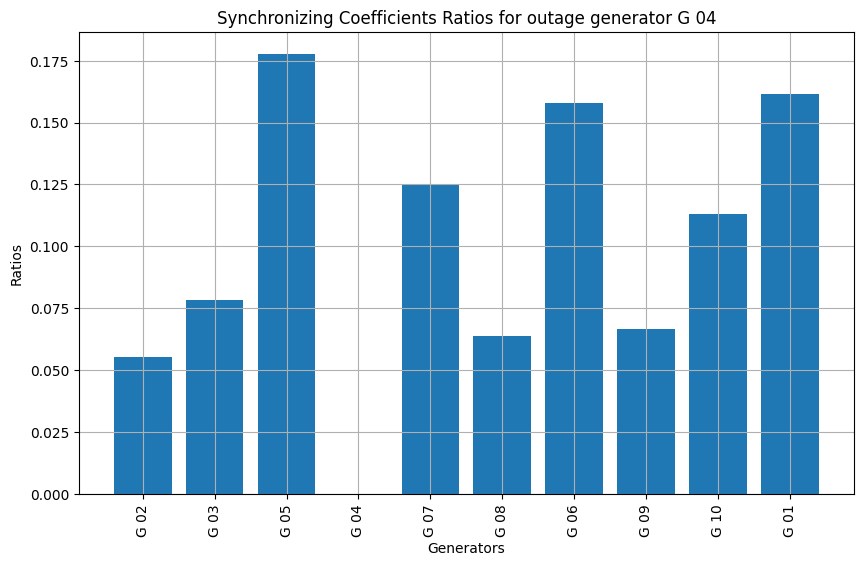

In [7]:
# Convert generator_bus_names to generator_names order
generator_names_order = [network.get_generator_name_from_busbar(bus) for bus in generator_bus_names_order]

# Plot the ratios
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(generator_names_order, ratios)
plt.xlabel('Generators')
plt.ylabel('Ratios')
plt.title('Synchronizing Coefficients Ratios for outage generator {}'.format(GEN_OUT))
plt.xticks(rotation=90)
plt.grid(True)
plt.show()